In [6]:
import os 
import numpy as np
from PIL import Image
import cv2 
import matplotlib.pyplot as plt
from nuscenes.nuscenes import NuScenes
from data.build_nuscenes.build_dataset import make_nuscenes_dataset,get_calibration_P, get_sample_data_ego_pose_P, get_camera_K, accumulate_lidar_points, downsample_with_reflectance
from data.kitti_helper import camera_matrix_cropping, camera_matrix_scaling
from data.options import Options_Nuscenes
%matplotlib inline

root_path = '/data/nuscenes'
nuscenes_path = os.path.join(root_path, 'test')
version = 'v1.0-test'

dataset = make_nuscenes_dataset(nuscenes_path)
nusc = NuScenes(version=version, dataroot=nuscenes_path, verbose=True)

Loading NuScenes tables for version v1.0-test...
32 category,
8 attribute,
4 visibility,
0 instance,
12 sensor,
1800 calibrated_sensor,
462901 ego_pose,
15 log,
150 scene,
6008 sample,
462901 sample_data,
0 sample_annotation,
4 map,
Done loading in 2.049 seconds.
Reverse indexing ...
Done reverse indexing in 0.5 seconds.


GT pose visualization

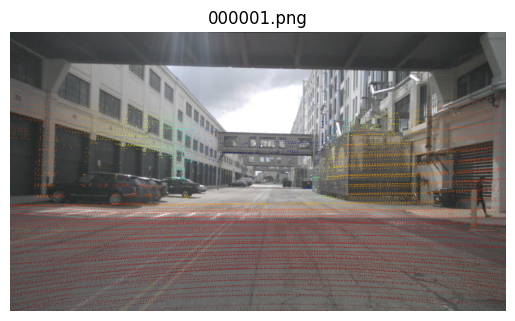

In [5]:
processed_root_path = '../nuscenes_i2p/test'
opt = Options_Nuscenes()

processed_root_file = sorted(os.listdir(os.path.join(processed_root_path, 'pc'))) 
global_index_list = []
for i in range(len(processed_root_file)):
    global_index = int(processed_root_file[i].split('.')[0])
    global_index_list.append(global_index)

valid_pair = False
i = 0
while valid_pair is False:
    global_idx = global_index_list[i]
    # print(global_idx)
    item = dataset[global_idx]

    lidar_token=item[0]
    # print(lidar_token)
    nearby_cam_token_dict=item[1]

    lidar=nusc.get('sample_data',lidar_token)
    lidar_calib_P = get_calibration_P(nusc, lidar)
    lidar_pose_P = get_sample_data_ego_pose_P(nusc, lidar)
    pc_np, intensity_np,pc_np_curr,intensity_np_curr = accumulate_lidar_points(nusc,lidar)
    pc_np_ori = np.copy(pc_np).astype(np.float32)
    intensity_np_ori = np.copy(intensity_np).astype(np.float32)
    # print(pc_np.shape)
    if pc_np.shape[1] < 45000:
        print("id %d, num_pc=%d, < 45000!"%(i,len(dataset),pc_np.shape[1]))
        i += 1
        continue
    else:
        pc_np,intensity_np=downsample_with_reflectance(pc_np,intensity_np[0],voxel_grid_downsample_size=0.2)
        intensity_np=np.expand_dims(intensity_np,axis=0)
        pc_np=pc_np.astype(np.float32)
        intensity_np=intensity_np.astype(np.float32)
        if pc_np.shape[1] < 45000:
            print("id %d, num_pc=%d, < 45000 after downsample!"%(i,len(dataset),pc_np.shape[1]))
            i += 1
            continue

    nearby_cam_token_list = nearby_cam_token_dict['CAM_FRONT']
    for nearby_camera_token in nearby_cam_token_list:
        camera = nusc.get('sample_data', nearby_camera_token)
        img = np.array(Image.open(os.path.join(nusc.dataroot, camera['filename'])))
        K = get_camera_K(nusc, camera)
        # K_ = K

        img_= img[opt.crop_original_top_rows:, :, :]
        K_ = camera_matrix_cropping(K, dx=0, dy=opt.crop_original_top_rows)
        # scale
        img_ = cv2.resize(img_,
                        (int(round(img_.shape[1] * opt.img_scale)),
                        int(round((img_.shape[0] * opt.img_scale)))),
                        interpolation=cv2.INTER_LINEAR)
        K_ = camera_matrix_scaling(K_, opt.img_scale)

        camera_calib_P = get_calibration_P(nusc, camera)
        camera_pose_P = get_sample_data_ego_pose_P(nusc, camera)

        camera_pose_P_inv = np.linalg.inv(camera_pose_P)
        camera_calib_P_inv = np.linalg.inv(camera_calib_P)
        P_cam_pc = np.dot(camera_calib_P_inv, np.dot(camera_pose_P_inv,
                                                    np.dot(lidar_pose_P, lidar_calib_P)))
        pc_np_2 = np.dot(P_cam_pc[0:3, 0:3], pc_np) + P_cam_pc[0:3, 3:]
        pc_np_ori_2 = np.dot(P_cam_pc[0:3, 0:3], pc_np_ori) + P_cam_pc[0:3, 3:]

        H = img.shape[0]
        W = img.shape[1]
        uvz = np.dot(K, pc_np_ori_2) # proj to origin image
        depth = uvz[2, :]
        uv = np.floor(uvz[0:2, :] / uvz[2:, :])

        
        H_ = img_.shape[0]
        W_ = img_.shape[1]
        uvz_ = np.dot(K_, pc_np_2)
        depth_ = uvz_[2, :]
        uv_ = uvz_[0:2, :] / uvz_[2:, :]

        inside_point_num = np.sum((depth_ > 0) & (uv_[0, :] >= 0) & (uv_[0, :] <= W_ - 1) & (uv_[1, :] >= 0) & (uv_[1, :] <= H_ - 1))
        if inside_point_num > 6000:

            is_in_picture = (uvz[2, :] > 0) & (uv[0, :] >= 0) & (uv[0, :] <= W - 1) & (uv[1, :] >= 0) & (uv[1, :] <= H - 1)

            # print(uv.shape, is_in_picture.shape)
            xy_inline = uv[:,is_in_picture]
            colormap = cv2.COLORMAP_JET
            # norm depth
            depth = depth[is_in_picture]
            depth_norm = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))
            # print(depth_norm.max(), depth_norm.min())
            color = (depth_norm * 255).astype(np.uint8)
            color_mapped = cv2.applyColorMap(color, colormap)
            for j in range(xy_inline.shape[1]):
                cv2.circle(img, (int(xy_inline[0, j]), int(xy_inline[1, j])), 1, [int(color_mapped[j, 0 , 0]), 
                                                                                int(color_mapped[j, 0 , 1]), int(color_mapped[j, 0 , 2])], thickness=1)
            # cv2.imwrite("xxx.png",img)
            valid_pair = True
            break
        else:
            print("points fall onto the image plane less than 6000, skip!")
            # i += 1
            continue
    i += 1

plt.imshow(img)
plt.title("%06d.png"%i)
plt.axis("off")
plt.show()
            


Estimated pose visulization (future work)